In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

from models.encoder_model import SpecialTransformer, IntegralSpecialTransformer
from utils.visualization import plot_attention_heatmap
from utils.context_encoding import ContextEncoder
from utils.preprocessing import *

### Dataset Preparation

In [2]:
df = pd.read_csv(r"./dataset/dst.csv")
df.head()

,timestamp,Scalar_B,BX_GSE,BY_GSE,BY_GSM,BZ_GSM,Sigma_BX,Sigma_BY,Sigma_BZ,SW_Temp,...,SW_Speed,SW_Flow_long,SW_Flow_lat,AP_Density,Sigma_T,Sigma_n,Sigma_V,Flow_Pressure,E_Field,Dst
0,946684800,7.5,-5.6,2.5,2.2,1.6,1.6,1.5,2.7,324194.0,...,675.0,0.9,-4.0,NaN,41773.0,0.3,13.0,2.64,-1.08,-45
1,946688400,7.8,-4.9,3.9,4.7,-2.7,1.1,1.1,1.1,302235.0,...,677.0,0.5,-0.5,NaN,21258.0,0.3,8.0,2.38,1.83,-37
2,946692000,7.6,-2.7,4.9,5.3,-1.6,1.7,1.3,2.6,349786.0,...,708.0,-0.2,-1.0,NaN,29110.0,0.3,21.0,2.21,1.13,-37
3,946695600,7.4,-3.9,2.9,3.3,-2.3,1.6,2.5,2.6,362297.0,...,706.0,1.5,-0.7,NaN,30728.0,0.1,20.0,2.09,1.62,-41
4,946699200,7.0,-3.5,1.8,1.9,-1.2,1.8,4.2,2.2,429384.0,...,721.0,1.8,-2.5,NaN,33149.0,0.1,18.0,2.08,0.87,-45


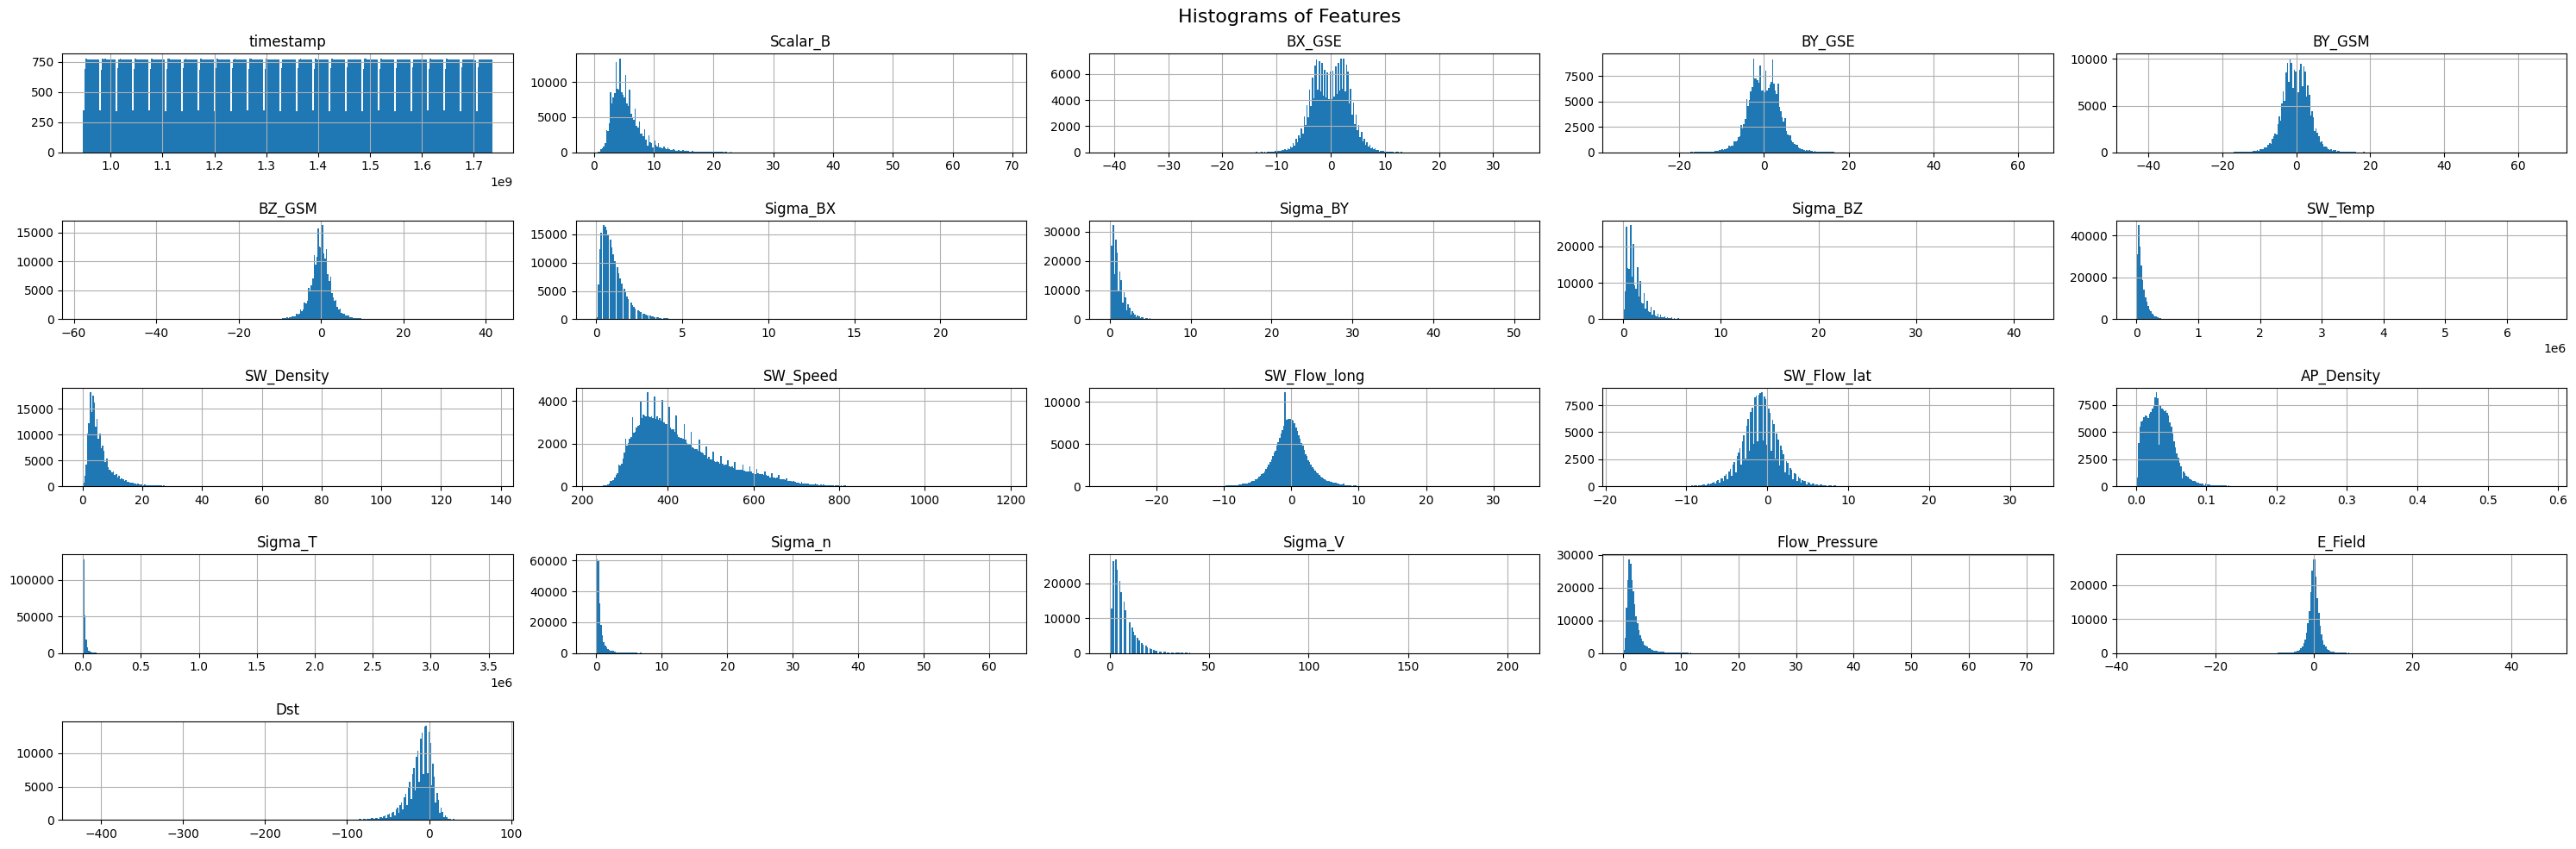

In [3]:
df.hist(figsize=(30, 10), bins=300)  # Added bins=20 for finer granularity
plt.suptitle("Histograms of Features", fontsize=16)
plt.tight_layout()
plt.show()

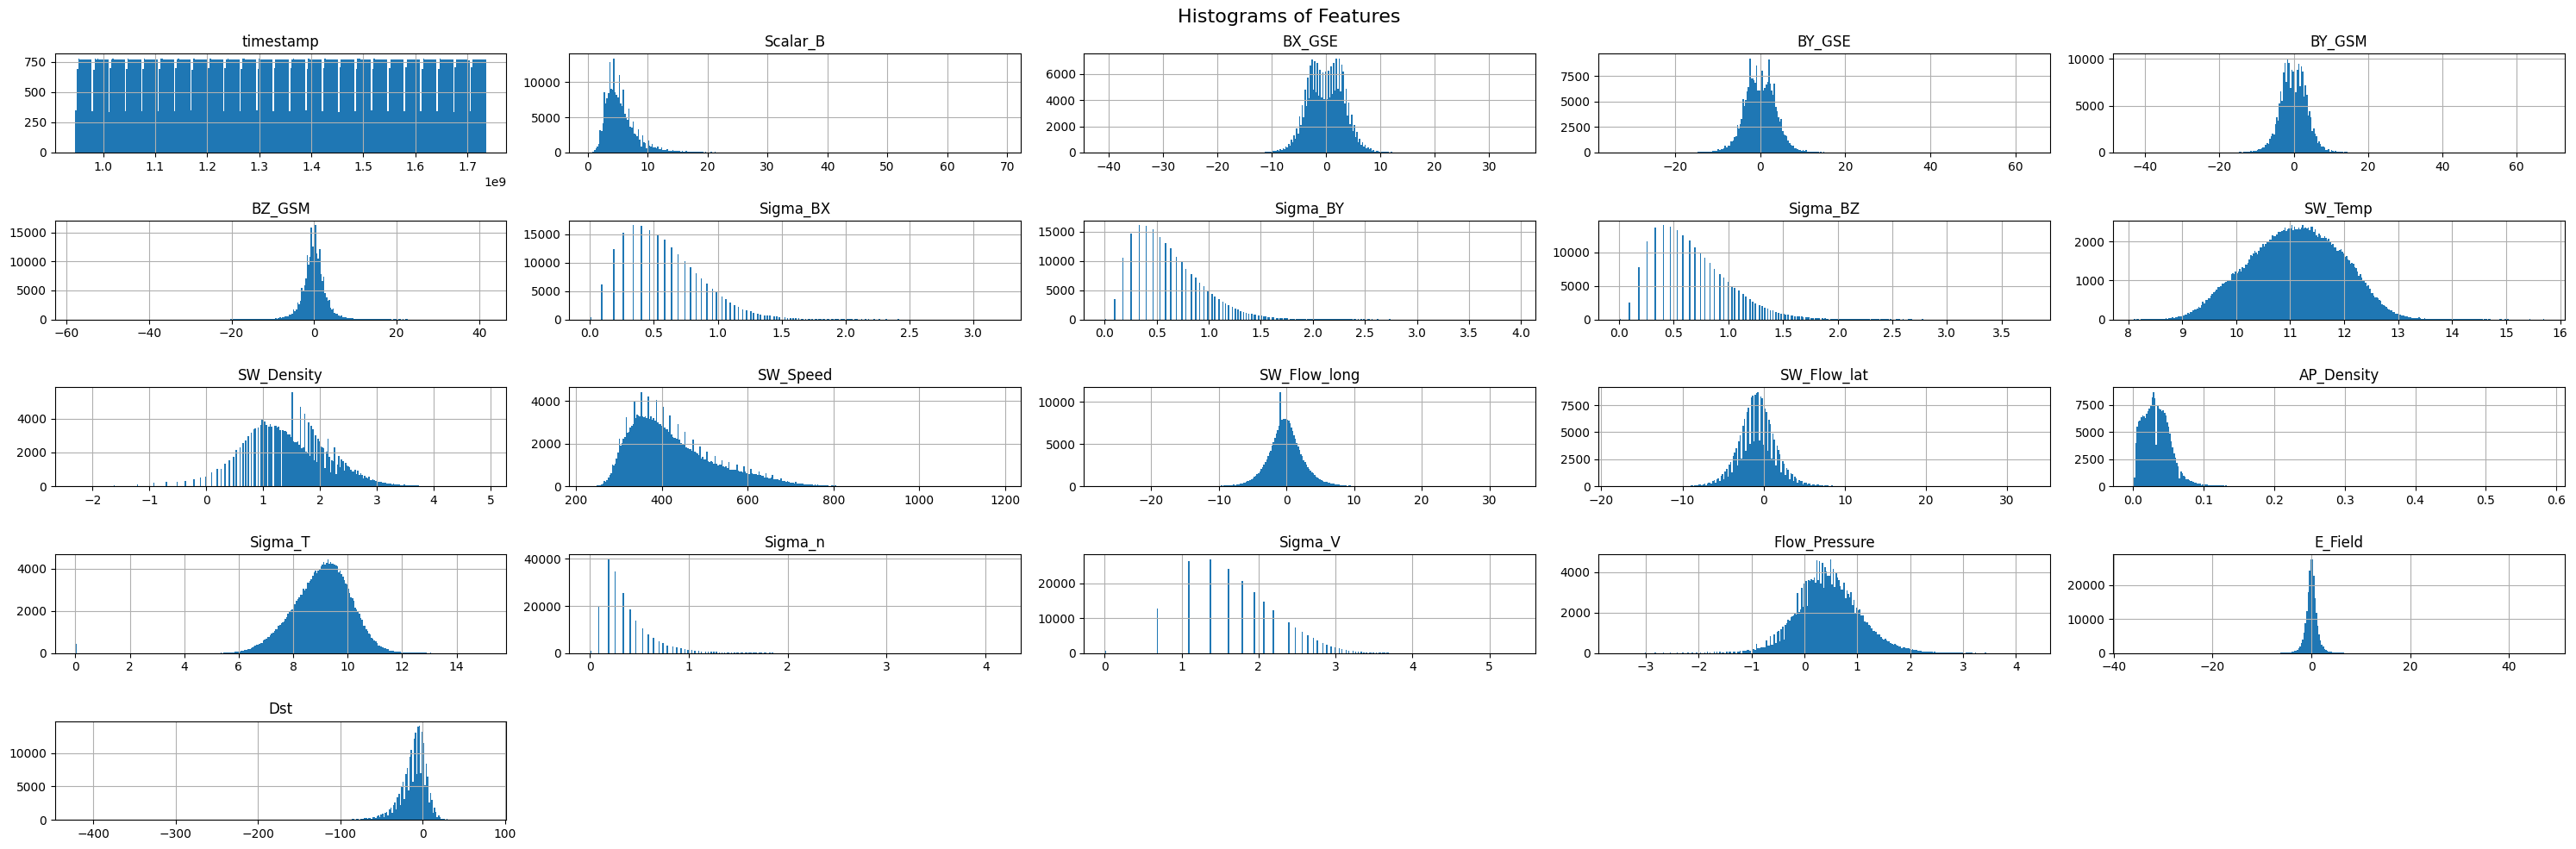

In [4]:
cols_to_log_transform = ["Sigma_BX", "Sigma_BY", "Sigma_BZ", "SW_Temp", "SW_Density", "Sigma_T", "Sigma_n", "Sigma_V", "Flow_Pressure"]

df_log = df.copy()  # Work on a *copy* of the DataFrame

for col in cols_to_log_transform:
    if col in df_log.columns:
        # Handle zeros/negatives and apply log1p.  MUCH more robust.
        min_val = df_log[col].min()
        if min_val <= 0:  # Check if non-positive values exist
            # print(f"Column '{col}' has non-positive values. Applying log1p after shifting.")
            shift_value = abs(min_val) + 1e-6  # Add a *small* constant to avoid log(0)
            df_log[col] = np.log1p(df_log[col] + shift_value)  # Use log1p
        else:
            # print(f"Column '{col}' has only positive values. Applying log directly.")
            df_log[col] = np.log(df_log[col])  # Regular log (if all positive)


df_log.hist(figsize=(30, 10), bins=300)  # Added bins=20 for finer granularity
plt.suptitle("Histograms of Features", fontsize=16)
plt.tight_layout()
plt.show()

df_log.to_csv(r"./dataset/dst_log.csv", index=False)

In [5]:
feature_cols = list(df.columns)
feature_cols.remove("Dst")
feature_cols.remove("timestamp")

target_col = 'Dst'
context_cols = ['timestamp']
numerical_features_info = {k:"standard" for k in feature_cols}

dataset = TabularDataset(
    data_path=r"./dataset/dst_log.csv",
    feature_cols=feature_cols,
    target_col=target_col,
    context_cols=context_cols,
    numerical_features_info=numerical_features_info,
    outlier_removal=True,
    outlier_std_threshold=3
)

/home/useradmin/train/SpaceScienceXAI/utils/preprocessing.py:134: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data['prev_target'] = self.data[self.target_col].shift(1).fillna(method='bfill')


In [6]:
batch_size = 72
num_features = len(feature_cols)

In [7]:
train_dataset, val_dataset, test_dataset = split_data(dataset, train_ratio=0.65, val_ratio=0.20, test_ratio=0.15)
train_loader = create_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = create_dataloader(val_dataset, batch_size=5048, shuffle=True)

### Define Important Module

In [8]:
config_path = r"./exper.json"
context_cols = {"time": "time"}
embedding = ContextEncoder(context_cols, config_path)
# model = SpecialTransformer(config_path)
model = IntegralSpecialTransformer(config_path, num_features, 5)

In [9]:
sample = next(iter(train_loader))

features = sample['features'].unsqueeze_(dim=-1)

input_context = torch.tensor(np.array([v.cpu().numpy() for k, v in sample['context'].items()]))
context_embedding = embedding(input_context, 'cpu')

print("Input Matrix")
print("-"*20)
print(features.size())
print(context_embedding.size())
print("-"*20)
 
outputs = model(features, context_embedding)

print(outputs.size())

Input Matrix
--------------------
torch.Size([72, 20, 1])
torch.Size([72, 5, 64])
--------------------
torch.Size([72, 1])


### Create the training loop

In [10]:
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
emb_optimizer = torch.optim.AdamW(embedding.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.7, min_lr=1e-5)
emb_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(emb_optimizer, 'min', patience=15, factor=0.7, min_lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
embedding = embedding.to(device)

print(device)

cuda


In [11]:
# weights = torch.load("./weights/checkpint.pth", weights_only=False)
# model.load_state_dict(weights["model_state_dict"])
# embedding.load_state_dict(weights["context_encoder"])

In [12]:
# for param in embedding.parameters():
#     param.requires_grad_(False)

In [13]:
num_epochs = 100
best_val_loss = float('inf')
train_losses = []  # Store training losses
val_losses = []    # Store validation losses
for epoch in tqdm(range(1, num_epochs+1)):
    model.train()  # Set the model to training mode
    embedding.train()
    running_loss = 0.0
    for batches in train_loader:
        # Move data to the device
        features = batches["features"].to(device)
        targets = batches["target"].to(device)
        input_context = torch.tensor(np.array([v.cpu().numpy() for k, v in batches["context"].items()]))
        input_context = input_context.to(device)
        context = embedding(input_context, device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features.unsqueeze_(dim=-1), context)
        
        # Calculate the loss
        loss = criterion(outputs.squeeze(), targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        emb_optimizer.step()
        running_loss += loss.item() * features.size(0)  # Accumulate loss for the epoch
        
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) # Append average loss
    
    # --- Validation Loop ---
    model.eval()  # Set the model to evaluation mode
    embedding.eval()
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculations during validation
        for batches in val_loader:
            features = batches["features"].to(device)
            targets = batches["target"].to(device)
            input_context = torch.tensor(np.array([v.cpu().numpy() for k, v in batches["context"].items()]))
            input_context = input_context.to(device)
            context = embedding(input_context)
            
            # Forward pass
            outputs = model(features.unsqueeze_(dim=-1), context)
            loss = criterion(outputs.squeeze(), targets)
            running_val_loss += loss.item() * features.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    emb_scheduler.step(epoch_val_loss)
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save({"model_state_dict": model.state_dict(), "context_encoder": embedding.state_dict()}, r"./weights/best.pth")
    
    if epoch%5 == 0 or epoch == 1:
        print(f"Train || epoch {epoch} train loss: {epoch_train_loss}")
        print(f"Validate || epoch {epoch} val loss: {epoch_val_loss}")
        print(f"Running learning rate {optimizer.param_groups[0]["lr"]}")

  1%|          | 1/100 [00:27<46:00, 27.88s/it]

Train || epoch 1 train loss: 0.09106695480696167
Validate || epoch 1 val loss: 0.03088839648495181
Running learning rate 0.001


  5%|▌         | 5/100 [02:17<43:19, 27.36s/it]

Train || epoch 5 train loss: 0.02932882202361712
Validate || epoch 5 val loss: 0.027720224810349886
Running learning rate 0.001


 10%|█         | 10/100 [04:34<41:06, 27.41s/it]

Train || epoch 10 train loss: 0.028476303447627412
Validate || epoch 10 val loss: 0.02593876260878418
Running learning rate 0.001


 15%|█▌        | 15/100 [06:51<38:50, 27.42s/it]

Train || epoch 15 train loss: 0.028521034597800744
Validate || epoch 15 val loss: 0.02584563080888897
Running learning rate 0.001


 20%|██        | 20/100 [09:08<36:31, 27.39s/it]

Train || epoch 20 train loss: 0.027349106088021477
Validate || epoch 20 val loss: 0.02564359420300531
Running learning rate 0.001


 25%|██▌       | 25/100 [11:25<34:14, 27.39s/it]

Train || epoch 25 train loss: 0.026643339481774456
Validate || epoch 25 val loss: 0.025349163422212714
Running learning rate 0.001


 30%|███       | 30/100 [13:41<31:49, 27.27s/it]

Train || epoch 30 train loss: 0.026652676316192888
Validate || epoch 30 val loss: 0.026000780497787725
Running learning rate 0.001


 35%|███▌      | 35/100 [15:58<29:40, 27.38s/it]

Train || epoch 35 train loss: 0.026423659689876013
Validate || epoch 35 val loss: 0.025480185252057107
Running learning rate 0.0007


 40%|████      | 40/100 [18:15<27:17, 27.29s/it]

Train || epoch 40 train loss: 0.026378399184627865
Validate || epoch 40 val loss: 0.02560003893167323
Running learning rate 0.0007


 45%|████▌     | 45/100 [20:31<25:03, 27.34s/it]

Train || epoch 45 train loss: 0.02630929607834923
Validate || epoch 45 val loss: 0.026294612944045902
Running learning rate 0.0007


 50%|█████     | 50/100 [22:48<22:45, 27.31s/it]

Train || epoch 50 train loss: 0.02697992316427076
Validate || epoch 50 val loss: 0.0254139738359574
Running learning rate 0.0007


 55%|█████▌    | 55/100 [25:05<20:32, 27.40s/it]

Train || epoch 55 train loss: 0.025774600638877404
Validate || epoch 55 val loss: 0.025077824919488508
Running learning rate 0.00049


 60%|██████    | 60/100 [27:22<18:12, 27.31s/it]

Train || epoch 60 train loss: 0.02575384800724843
Validate || epoch 60 val loss: 0.025321129642427987
Running learning rate 0.00049


 65%|██████▌   | 65/100 [29:38<15:54, 27.27s/it]

Train || epoch 65 train loss: 0.02602699074092585
Validate || epoch 65 val loss: 0.025122396392801217
Running learning rate 0.00049


 70%|███████   | 70/100 [31:54<13:37, 27.25s/it]

Train || epoch 70 train loss: 0.025863686076678858
Validate || epoch 70 val loss: 0.025468502095190203
Running learning rate 0.00049


 75%|███████▌  | 75/100 [34:10<11:20, 27.20s/it]

Train || epoch 75 train loss: 0.025823099709156364
Validate || epoch 75 val loss: 0.025306672759708677
Running learning rate 0.00049


 80%|████████  | 80/100 [36:26<09:04, 27.20s/it]

Train || epoch 80 train loss: 0.025866224789921448
Validate || epoch 80 val loss: 0.024938888287598097
Running learning rate 0.00049


 85%|████████▌ | 85/100 [38:42<06:48, 27.22s/it]

Train || epoch 85 train loss: 0.026334398376260355
Validate || epoch 85 val loss: 0.025022986319964642
Running learning rate 0.00049


 90%|█████████ | 90/100 [40:59<04:32, 27.27s/it]

Train || epoch 90 train loss: 0.025878278641903736
Validate || epoch 90 val loss: 0.025702281287550605
Running learning rate 0.00049


 95%|█████████▌| 95/100 [43:15<02:16, 27.21s/it]

Train || epoch 95 train loss: 0.026069209931836205
Validate || epoch 95 val loss: 0.024973907697942943
Running learning rate 0.000343


100%|██████████| 100/100 [45:32<00:00, 27.32s/it]

Train || epoch 100 train loss: 0.025526827137153332
Validate || epoch 100 val loss: 0.025201335395614304
Running learning rate 0.000343


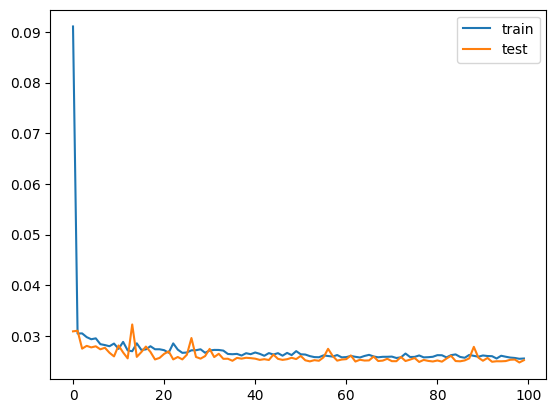

In [14]:
plt.plot(range(len(train_losses)), train_losses, label="train")
plt.plot(range(len(val_losses)), val_losses, label="test")
plt.legend()
plt.show()

In [57]:
test_loader = create_dataloader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [47]:
inputs_set = {"normal": [], "exte": []}
normal_count = 3
exterem_count = 3
for batches in test_loader:
    # print(batches["features"].mean())
    
    if normal_count > 0 and batches["target"].mean() < 1 and batches["target"].mean() > -1:
        inputs_set["normal"].append(batches["features"])
        print("normal:", normal_count)
        normal_count -= 1
    
    elif exterem_count > 0 and (batches["target"].mean() > 2 or batches["target"].mean() < -2):
        inputs_set["exte"].append(batches["features"])
        print("exte:", exterem_count)
        exterem_count -= 1
        
    if normal_count == 0 and exterem_count == 0:
        break

normal: 3
normal: 2
normal: 1
exte: 3
exte: 2
exte: 1


In [48]:
weights = torch.load("./weights/best.pth", weights_only=False)
model.load_state_dict(weights["model_state_dict"])
embedding.load_state_dict(weights["context_encoder"])

<All keys matched successfully>

torch.Size([32875, 20, 20])
torch.Size([20, 20])


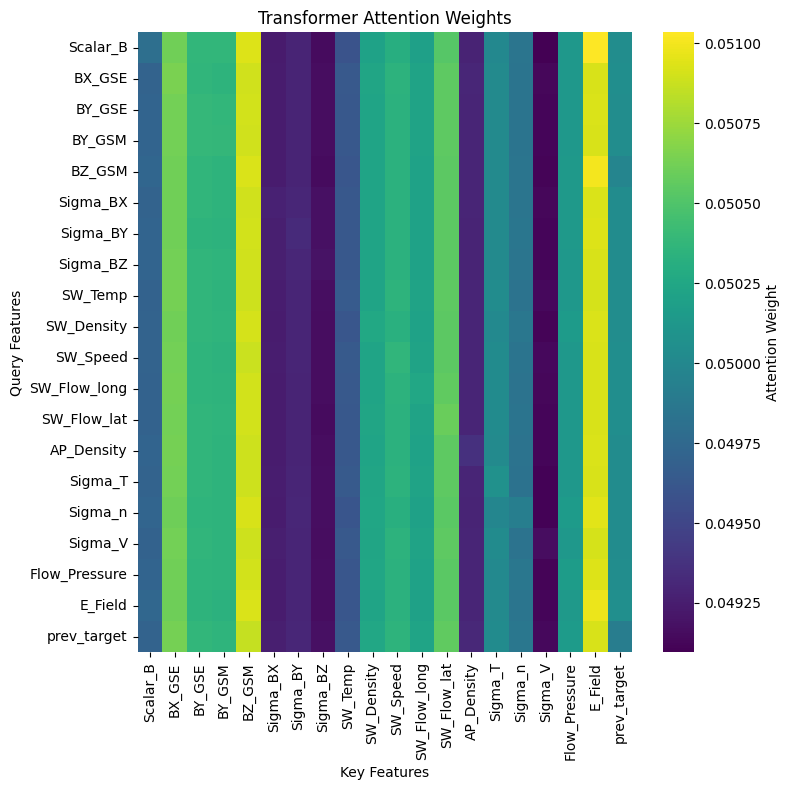

In [58]:
model.eval()  # Put the model in evaluation mode
with torch.no_grad():  # Disable gradient calculations
    #features = inputs_set["normal"][1].to(device)
    features = next(iter(test_loader))["features"].to(device)
    attention_weights = model.get_attention_weights(features.unsqueeze_(dim=-1))

print(attention_weights[0].size())
average_attention = torch.mean(torch.concat(attention_weights, dim=0), dim=0)
print(average_attention.size())

single_batch_attention = average_attention.cpu().numpy()  # Single batch

# --- Create Feature Labels (IMPORTANT) ---
# feature_cols.extend(["hour_sin", "hour_cos", "day_sin", "day_cos", "year"])
feature_names = [feature_cols[i] for i in range(single_batch_attention.shape[1])]  # Replace with YOUR feature names if available

# --- Visualize the Heatmap ---
plot_attention_heatmap(single_batch_attention, feature_names, figsize=(8, 8))

In [37]:
test_loader = test_loader = create_dataloader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model.eval()
embedding.eval()

with torch.no_grad():
    
    targets = []
    outputs = []
    
    for batches in test_loader:
        features = batches["features"].to(device)
        targets = batches["target"].to(device)
        input_context = torch.tensor(np.array([v.cpu().numpy() for k, v in batches["context"].items()]))
        input_context = input_context.to(device)
        context = embedding(input_context, device)
        
        # Forward pass
        outputs = model(features.unsqueeze_(dim=-1), context)
        
    print(nn.MSELoss()(outputs.squeeze(), targets))


targets = targets.detach().cpu().numpy()
outputs = outputs.squeeze().detach().cpu().numpy()

tensor(0.2357, device='cuda:0')


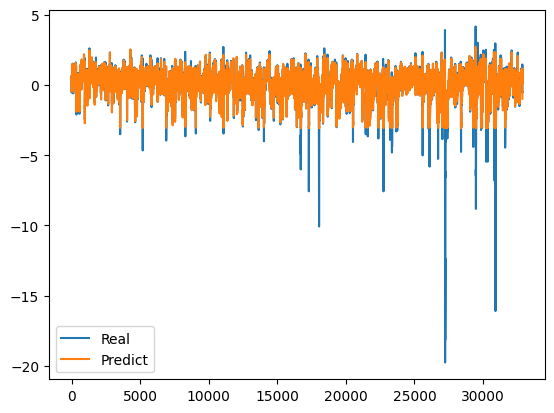

In [40]:
plt.plot(range(len(targets)), targets, label="Real")
plt.plot(range(len(outputs)), outputs, label="Predict")
plt.legend()
# plt.xlim((0, 7000))
plt.show()